## Assignment

In this exercise, we'll predict house prices using our model. We will complete the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

In [2]:
# Libraries 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import warnings

# Import data

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
# Create dummy variables 
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.housestyle, prefix="style", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.housestyle, prefix="style", drop_first=True).columns)

In [4]:
# Create new variables 
houseprices_df['totalsf'] = houseprices_df['totalbsmtsf'] + houseprices_df['firstflrsf'] + houseprices_df['secondflrsf']

houseprices_df['int_over_sf'] = houseprices_df['totalsf'] * houseprices_df['overallqual']

In [5]:
# Y is the target variable
Y = np.log1p(houseprices_df['saleprice'])
# X is the feature set
X = houseprices_df[['overallqual','grlivarea','garagearea','totalbsmtsf','firstflrsf', 'int_over_sf'] + dummy_column_names]

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [7]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     328.4
Date:                Mon, 12 Aug 2019   Prob (F-statistic):               0.00
Time:                        02:34:12   Log-Likelihood:                 453.88
No. Observations:                1168   AIC:                            -871.8
Df Residuals:                    1150   BIC:                            -780.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.7435      0.080    122.439   

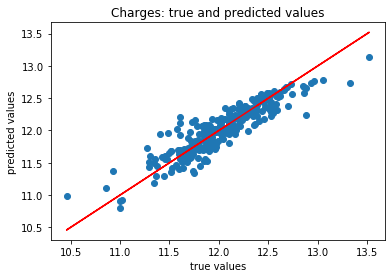

Mean absolute error of the prediction is: 0.12885874941200418
Mean squared error of the prediction is: 0.02988341865051028
Root mean squared error of the prediction is: 0.172868211798787
Mean absolute percentage error of the prediction is: 1.0765115436157937


In [8]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

